In [1]:
# Import necessary libraries
import requests, zipfile, io
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
from torchtext.vocab import GloVe
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
global_vectors = GloVe(name='840B', dim=300)

AttributeError: module 'inspect' has no attribute 'formatargspec'

In [ ]:
# Download and extract dataset
r = requests.get('http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content")

In [ ]:
# Create Pandas Dataframe
train = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='latin', header=None)
test = pd.read_csv('/content/testdata.manual.2009.06.14.csv', encoding='latin', header=None)

train = train.sample(n = 10000)

In [ ]:
train.head()

,0,1,2,3,4,5
819991,4,1553584784,Sat Apr 18 14:39:52 PDT 2009,NO_QUERY,SymonVT,"Love U Armin, ASOT400 rox!Greetz From Croatia"
13771,0,1553394668,Sat Apr 18 14:09:03 PDT 2009,NO_QUERY,lindadominique,@RachelsDestiny I took photos but I have to bu...
327430,0,2009600750,Tue Jun 02 15:58:05 PDT 2009,NO_QUERY,arwenwoods,"Rest in peace, Corinne, darling. You'll be sor..."
1336052,4,2017132711,Wed Jun 03 07:54:44 PDT 2009,NO_QUERY,roxytweets,@westlifebunny O_O Thank goodness your mum's a...
1556683,4,2185422757,Mon Jun 15 17:21:32 PDT 2009,NO_QUERY,shopmollyd,@MJthedog I just followed


In [ ]:
def preprocess(df):

  # Convert all text to lowercase
  df[5] = df[5].str.lower()

  # Expand clitic contractions
  clitic_pattern = r"b(he|she|it|we|they|I|you|that|there|what|who|how|where|when|why)'([a-zA-Z]+)\b"
  df[5] = df[5].apply(lambda x: re.sub(clitic_pattern, r"\1 \2", x))

  # Remove URLs
  df[5] = df[5].apply(lambda x: re.sub('http://\S+|https://\S+','',x))

  # Remove punctuation marks
  df[5] = df[5].apply(lambda x: re.sub(r'[^\w\s]','',x))

  # Tokenization
  df[5] = df[5].apply(lambda x: word_tokenize(x))

  # Stop word removal
  stop_words = set(stopwords.words('english'))
  df[5] = df[5].apply(lambda x: [word for word in x if word not in stop_words])

  # Stemming
  stemmer = PorterStemmer()
  df[5] = df[5].apply(lambda x: [stemmer.stem(word) for word in x])

  return(df)

preprocessed_train = preprocess(train)
preprocessed_test = preprocess(test)

In [ ]:
# Map labels to binary values
label_mapping = {0: 0, 4: 1}  # Example mapping
preprocessed_train[0] = preprocessed_train[0].replace(label_mapping)
preprocessed_test[0] = preprocessed_test[0].replace(label_mapping)
preprocessed_test = preprocessed_test[preprocessed_test[0] != 2]


In [ ]:
# First, create a tokenizer to convert words to numerical values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_train[5])

# Next, convert the lists to numerical values using the tokenizer
sequences_train = tokenizer.texts_to_sequences(preprocessed_train[5])
sequences_test = tokenizer.texts_to_sequences(preprocessed_test[5])

# Finally, pad the sequences so that they are all the same length
max_len = 33
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_len, padding='pre')
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_len, padding='pre')

In [ ]:
# Initialize empty list
list_col_train = []
list_col_test = []

# Loop over each row and append a list of length 25
for i in range(preprocessed_train.shape[0]):
    list_col_train.append(padded_sequences_train[i])
for j in range(preprocessed_test.shape[0]):
    list_col_test.append(padded_sequences_test[j])

# Assign the resulting list as a new column in the DataFrame
preprocessed_train[6] = list_col_train
preprocessed_test[6] = list_col_test

<ipython-input-8-eff441045597>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessed_test[6] = list_col_test


In [ ]:
# Pad the sentences
lists_train = preprocessed_train[5]
for lst in lists_train:
    while len(lst) < max_len:
        lst.insert(0, " ")

lists_test = preprocessed_test[5]
for lst in lists_test:
    while len(lst) < max_len:
        lst.insert(0, " ")

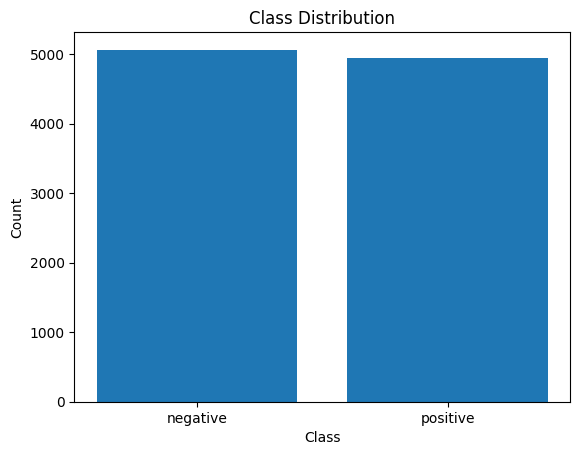

In [ ]:
# Distribution of classes
plt.bar(['negative', 'positive'], preprocessed_train[0].value_counts())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
# Convert the train DataFrame to a PyTorch tensor
X_train = preprocessed_train[6].to_numpy()
y_train = preprocessed_train[0].to_numpy()
X_train = np.vstack(X_train).astype(np.float)
X_train = torch.from_numpy(np.array(X_train))
y_train = torch.from_numpy(np.array(y_train))
X_train = X_train.resize(X_train.size()[0], 1, max_len)

# Convert the test DataFrame to a PyTorch tensor
X_test = preprocessed_test[6].to_numpy()
y_test = preprocessed_test[0].to_numpy()
X_test = np.vstack(X_test).astype(np.float)
X_test = torch.from_numpy(np.array(X_test))
y_test = torch.from_numpy(np.array(y_test))
X_test = X_test.resize(X_test.size()[0], 1, max_len)

<ipython-input-11-ad0eb7318df4>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = np.vstack(X_train).astype(np.float)
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
<ipython-input-11-ad0eb7318df4>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20

In [ ]:
# Get the embeddings
sentences_train = preprocessed_train[5].to_numpy()
sentences_test = preprocessed_test[5].to_numpy()

embedding_train = []
for i in range(len(sentences_train)):
  try:
    embedding = global_vectors.get_vecs_by_tokens(sentences_train[i])
    embedding_train.append([embedding])
  except:
    pass

embedding_test = []
for j in range(len(sentences_test)):
  embedding = global_vectors.get_vecs_by_tokens(sentences_test[j])
  embedding_test.append([embedding])

In [ ]:
# Convert the list to a tensor
glove_tensor_train = torch.stack([torch.stack(sublist, dim=0) for sublist in embedding_train], dim=0)
glove_tensor_test = torch.stack([torch.stack(sublist, dim=0) for sublist in embedding_test], dim=0).resize(359, max_len, 300)

shape = glove_tensor_train.shape
glove_tensor_train = glove_tensor_train.resize(shape[0], shape[2], shape[3])

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the sequence
        return out

In [ ]:
class RNN_glove(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_glove, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the sequence
        return out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the sequence
        return out

In [ ]:
class LSTM_glove(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_glove, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the sequence
        return out

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the sequence
        return out

In [ ]:
class GRU_glove(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_glove, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the sequence
        return out

In [ ]:
# Define the hyperparameters
input_dim = max_len
input_dim_glove = 300
hidden_dim = 150
output_dim = 2
epochs = 20
lr = 0.001

In [ ]:
# Define the model, loss function, and optimizer
RNN = RNN(input_dim, hidden_dim, output_dim)
LSTM = LSTM(input_dim, hidden_dim, output_dim)
GRU = GRU(input_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss()

optimizer_RNN = torch.optim.Adam(RNN.parameters(), lr=lr)
optimizer_LSTM = torch.optim.Adam(LSTM.parameters(), lr=lr)
optimizer_GRU = torch.optim.Adam(LSTM.parameters(), lr=lr)

In [ ]:
# Define the model, loss function, and optimizer for glove
RNN_glove = RNN_glove(input_dim_glove, hidden_dim, output_dim)
LSTM_glove = LSTM_glove(input_dim_glove, hidden_dim, output_dim)
GRU_glove = GRU_glove(input_dim_glove, hidden_dim, output_dim)

optimizer_RNN_glove = torch.optim.Adam(RNN_glove.parameters(), lr=lr)
optimizer_LSTM_glove = torch.optim.Adam(LSTM_glove.parameters(), lr=lr)
optimizer_GRU_glove = torch.optim.Adam(GRU_glove.parameters(), lr=lr)

In [ ]:
# Train the RNN model
for epoch in tqdm(range(epochs)):
    RNN.train()
    optimizer_RNN.zero_grad()
    y_pred = RNN(X_train.float())
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer_RNN.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

 25%|██▌       | 5/20 [00:00<00:00, 19.70it/s]

Epoch 1/20, Loss: 0.7285
Epoch 2/20, Loss: 0.7171
Epoch 3/20, Loss: 0.7085
Epoch 4/20, Loss: 0.7034
Epoch 5/20, Loss: 0.7001


 50%|█████     | 10/20 [00:00<00:00, 19.93it/s]

Epoch 6/20, Loss: 0.6970
Epoch 7/20, Loss: 0.6944
Epoch 8/20, Loss: 0.6925
Epoch 9/20, Loss: 0.6907
Epoch 10/20, Loss: 0.6893


 70%|███████   | 14/20 [00:00<00:00, 19.26it/s]

Epoch 11/20, Loss: 0.6878
Epoch 12/20, Loss: 0.6863
Epoch 13/20, Loss: 0.6853
Epoch 14/20, Loss: 0.6844


 95%|█████████▌| 19/20 [00:00<00:00, 19.57it/s]

Epoch 15/20, Loss: 0.6831
Epoch 16/20, Loss: 0.6822
Epoch 17/20, Loss: 0.6813
Epoch 18/20, Loss: 0.6803
Epoch 19/20, Loss: 0.6797


100%|██████████| 20/20 [00:01<00:00, 19.42it/s]

Epoch 20/20, Loss: 0.6791


In [ ]:
RNN.eval()
y_pred = RNN(X_test.float())
_, predicted = torch.max(y_pred, 1)
accuracy = (predicted == y_test).sum().item() / len(y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4930


In [ ]:
confusion_matrix(predicted, y_test)

array([[102, 107],
       [ 75,  75]])

In [ ]:
# Train the RNN model on glove
for epoch in tqdm(range(epochs)):
    optimizer_RNN_glove.zero_grad()
    y_pred = RNN_glove(glove_tensor_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer_RNN_glove.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

  5%|▌         | 1/20 [00:03<01:06,  3.52s/it]

Epoch 1/20, Loss: 0.6978


 10%|█         | 2/20 [00:07<01:05,  3.67s/it]

Epoch 2/20, Loss: 0.6775


 15%|█▌        | 3/20 [00:10<01:01,  3.64s/it]

Epoch 3/20, Loss: 0.6599


 20%|██        | 4/20 [00:14<00:55,  3.45s/it]

Epoch 4/20, Loss: 0.6433


 25%|██▌       | 5/20 [00:17<00:50,  3.34s/it]

Epoch 5/20, Loss: 0.6266


 30%|███       | 6/20 [00:21<00:49,  3.54s/it]

Epoch 6/20, Loss: 0.6096


 35%|███▌      | 7/20 [00:24<00:44,  3.42s/it]

Epoch 7/20, Loss: 0.5939


 40%|████      | 8/20 [00:27<00:39,  3.33s/it]

Epoch 8/20, Loss: 0.5864


 45%|████▌     | 9/20 [00:30<00:36,  3.28s/it]

Epoch 9/20, Loss: 0.5761


 50%|█████     | 10/20 [00:34<00:34,  3.50s/it]

Epoch 10/20, Loss: 0.5644


 55%|█████▌    | 11/20 [00:37<00:30,  3.39s/it]

Epoch 11/20, Loss: 0.5617


 60%|██████    | 12/20 [00:40<00:26,  3.32s/it]

Epoch 12/20, Loss: 0.5615


 65%|██████▌   | 13/20 [00:44<00:22,  3.27s/it]

Epoch 13/20, Loss: 0.5550


 70%|███████   | 14/20 [00:48<00:20,  3.50s/it]

Epoch 14/20, Loss: 0.5493


 75%|███████▌  | 15/20 [00:51<00:16,  3.39s/it]

Epoch 15/20, Loss: 0.5434


 80%|████████  | 16/20 [00:54<00:13,  3.33s/it]

Epoch 16/20, Loss: 0.5393


 85%|████████▌ | 17/20 [00:57<00:10,  3.40s/it]

Epoch 17/20, Loss: 0.5360


 90%|█████████ | 18/20 [01:01<00:06,  3.46s/it]

Epoch 18/20, Loss: 0.5349


 95%|█████████▌| 19/20 [01:04<00:03,  3.36s/it]

Epoch 19/20, Loss: 0.5325


100%|██████████| 20/20 [01:07<00:00,  3.39s/it]

Epoch 20/20, Loss: 0.5283


In [ ]:
RNN_glove.eval()
y_pred = RNN_glove(glove_tensor_test.float())
_, predicted = torch.max(y_pred, 1)
accuracy = (predicted == y_test).sum().item() / len(y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7632


In [ ]:
confusion_matrix(predicted, y_test)

array([[134,  42],
       [ 43, 140]])

In [ ]:
# Train the LSTM model
for epoch in tqdm(range(epochs)):
    LSTM.train()
    optimizer_LSTM.zero_grad()
    y_pred = LSTM(X_train.float())
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer_LSTM.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

  5%|▌         | 1/20 [00:00<00:07,  2.54it/s]

Epoch 1/20, Loss: 0.7039


 10%|█         | 2/20 [00:00<00:06,  2.58it/s]

Epoch 2/20, Loss: 0.6982


 15%|█▌        | 3/20 [00:01<00:06,  2.57it/s]

Epoch 3/20, Loss: 0.6944


 20%|██        | 4/20 [00:01<00:06,  2.47it/s]

Epoch 4/20, Loss: 0.6918


 25%|██▌       | 5/20 [00:02<00:06,  2.25it/s]

Epoch 5/20, Loss: 0.6896


 30%|███       | 6/20 [00:02<00:06,  2.13it/s]

Epoch 6/20, Loss: 0.6874


 35%|███▌      | 7/20 [00:03<00:06,  2.05it/s]

Epoch 7/20, Loss: 0.6855


 40%|████      | 8/20 [00:03<00:05,  2.00it/s]

Epoch 8/20, Loss: 0.6842


 45%|████▌     | 9/20 [00:04<00:05,  2.02it/s]

Epoch 9/20, Loss: 0.6828


 50%|█████     | 10/20 [00:04<00:04,  2.19it/s]

Epoch 10/20, Loss: 0.6816


 55%|█████▌    | 11/20 [00:04<00:03,  2.31it/s]

Epoch 11/20, Loss: 0.6803


 60%|██████    | 12/20 [00:05<00:03,  2.39it/s]

Epoch 12/20, Loss: 0.6793


 65%|██████▌   | 13/20 [00:05<00:02,  2.48it/s]

Epoch 13/20, Loss: 0.6782


 70%|███████   | 14/20 [00:06<00:02,  2.54it/s]

Epoch 14/20, Loss: 0.6770


 75%|███████▌  | 15/20 [00:06<00:01,  2.59it/s]

Epoch 15/20, Loss: 0.6759


 80%|████████  | 16/20 [00:06<00:01,  2.63it/s]

Epoch 16/20, Loss: 0.6749


 85%|████████▌ | 17/20 [00:07<00:01,  2.63it/s]

Epoch 17/20, Loss: 0.6740


 90%|█████████ | 18/20 [00:07<00:00,  2.66it/s]

Epoch 18/20, Loss: 0.6730


 95%|█████████▌| 19/20 [00:07<00:00,  2.66it/s]

Epoch 19/20, Loss: 0.6723


100%|██████████| 20/20 [00:08<00:00,  2.42it/s]

Epoch 20/20, Loss: 0.6713


In [ ]:
LSTM.eval()
y_pred = LSTM(X_test.float())
_, predicted = torch.max(y_pred, 1)
accuracy = (predicted == y_test).sum().item() / len(y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4986


In [ ]:
confusion_matrix(predicted, y_test)

array([[103, 106],
       [ 74,  76]])

In [ ]:
# Train the LSTM model on glove
for epoch in tqdm(range(epochs)):
    optimizer_LSTM_glove.zero_grad()
    y_pred = LSTM_glove(glove_tensor_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer_LSTM_glove.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

  5%|▌         | 1/20 [00:15<04:45, 15.00s/it]

Epoch 1/20, Loss: 0.6944


 10%|█         | 2/20 [00:30<04:31, 15.08s/it]

Epoch 2/20, Loss: 0.6872


 15%|█▌        | 3/20 [00:46<04:26, 15.70s/it]

Epoch 3/20, Loss: 0.6806


 20%|██        | 4/20 [01:01<04:03, 15.23s/it]

Epoch 4/20, Loss: 0.6740


 25%|██▌       | 5/20 [01:15<03:43, 14.90s/it]

Epoch 5/20, Loss: 0.6669


 30%|███       | 6/20 [01:29<03:24, 14.62s/it]

Epoch 6/20, Loss: 0.6592


 35%|███▌      | 7/20 [01:48<03:28, 16.05s/it]

Epoch 7/20, Loss: 0.6508


 40%|████      | 8/20 [02:02<03:06, 15.55s/it]

Epoch 8/20, Loss: 0.6414


 45%|████▌     | 9/20 [02:17<02:47, 15.26s/it]

Epoch 9/20, Loss: 0.6310


 50%|█████     | 10/20 [02:32<02:32, 15.27s/it]

Epoch 10/20, Loss: 0.6194


 55%|█████▌    | 11/20 [02:47<02:14, 14.99s/it]

Epoch 11/20, Loss: 0.6069


 60%|██████    | 12/20 [03:01<01:58, 14.79s/it]

Epoch 12/20, Loss: 0.5946


 65%|██████▌   | 13/20 [03:15<01:41, 14.52s/it]

Epoch 13/20, Loss: 0.5845


 70%|███████   | 14/20 [03:29<01:25, 14.31s/it]

Epoch 14/20, Loss: 0.5805


 75%|███████▌  | 15/20 [03:42<01:10, 14.12s/it]

Epoch 15/20, Loss: 0.5807


 80%|████████  | 16/20 [03:57<00:56, 14.12s/it]

Epoch 16/20, Loss: 0.5775


 85%|████████▌ | 17/20 [04:12<00:43, 14.38s/it]

Epoch 17/20, Loss: 0.5699


 90%|█████████ | 18/20 [04:27<00:29, 14.72s/it]

Epoch 18/20, Loss: 0.5616


 95%|█████████▌| 19/20 [04:41<00:14, 14.63s/it]

Epoch 19/20, Loss: 0.5552


100%|██████████| 20/20 [04:56<00:00, 14.82s/it]

Epoch 20/20, Loss: 0.5513


In [ ]:
LSTM_glove.eval()
y_pred = LSTM_glove(glove_tensor_test.float())
_, predicted = torch.max(y_pred, 1)
accuracy = (predicted == y_test).sum().item() / len(y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7744


In [ ]:
confusion_matrix(predicted, y_test)

array([[138,  42],
       [ 39, 140]])

In [ ]:
# Train the GRU model
for epoch in tqdm(range(epochs)):
    GRU.train()
    optimizer_GRU.zero_grad()
    y_pred = GRU(X_train.float())
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer_GRU.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

 10%|█         | 2/20 [00:00<00:03,  5.57it/s]

Epoch 1/20, Loss: 0.7276
Epoch 2/20, Loss: 0.7276


 20%|██        | 4/20 [00:00<00:02,  5.77it/s]

Epoch 3/20, Loss: 0.7276
Epoch 4/20, Loss: 0.7276


 30%|███       | 6/20 [00:01<00:02,  6.00it/s]

Epoch 5/20, Loss: 0.7276
Epoch 6/20, Loss: 0.7276


 40%|████      | 8/20 [00:01<00:01,  6.14it/s]

Epoch 7/20, Loss: 0.7276
Epoch 8/20, Loss: 0.7276


 50%|█████     | 10/20 [00:01<00:01,  6.15it/s]

Epoch 9/20, Loss: 0.7276
Epoch 10/20, Loss: 0.7276


 55%|█████▌    | 11/20 [00:01<00:01,  5.79it/s]

Epoch 11/20, Loss: 0.7276


 60%|██████    | 12/20 [00:02<00:01,  5.38it/s]

Epoch 12/20, Loss: 0.7276


 65%|██████▌   | 13/20 [00:02<00:01,  5.16it/s]

Epoch 13/20, Loss: 0.7276


 70%|███████   | 14/20 [00:02<00:01,  5.04it/s]

Epoch 14/20, Loss: 0.7276


 75%|███████▌  | 15/20 [00:02<00:01,  4.92it/s]

Epoch 15/20, Loss: 0.7276


 80%|████████  | 16/20 [00:02<00:00,  4.76it/s]

Epoch 16/20, Loss: 0.7276


 85%|████████▌ | 17/20 [00:03<00:00,  4.70it/s]

Epoch 17/20, Loss: 0.7276


 90%|█████████ | 18/20 [00:03<00:00,  4.64it/s]

Epoch 18/20, Loss: 0.7276


 95%|█████████▌| 19/20 [00:03<00:00,  4.62it/s]

Epoch 19/20, Loss: 0.7276


100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

Epoch 20/20, Loss: 0.7276


In [ ]:
GRU.eval()
y_pred = GRU(X_test.float())
_, predicted = torch.max(y_pred, 1)
accuracy = (predicted == y_test).sum().item() / len(y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4624


In [ ]:
confusion_matrix(predicted, y_test)

array([[103, 119],
       [ 74,  63]])

In [ ]:
# Train the GRU model on glove
for epoch in tqdm(range(epochs)):
    optimizer_GRU_glove.zero_grad()
    y_pred = GRU_glove(glove_tensor_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer_GRU_glove.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

  5%|▌         | 1/20 [00:09<02:58,  9.41s/it]

Epoch 1/20, Loss: 0.6971


 10%|█         | 2/20 [00:18<02:46,  9.26s/it]

Epoch 2/20, Loss: 0.6845


 15%|█▌        | 3/20 [00:27<02:31,  8.92s/it]

Epoch 3/20, Loss: 0.6760


 20%|██        | 4/20 [00:36<02:23,  8.99s/it]

Epoch 4/20, Loss: 0.6669


 25%|██▌       | 5/20 [00:45<02:15,  9.02s/it]

Epoch 5/20, Loss: 0.6574


 30%|███       | 6/20 [00:54<02:08,  9.15s/it]

Epoch 6/20, Loss: 0.6483


 35%|███▌      | 7/20 [01:03<01:55,  8.89s/it]

Epoch 7/20, Loss: 0.6398


 40%|████      | 8/20 [01:12<01:47,  8.98s/it]

Epoch 8/20, Loss: 0.6314


 45%|████▌     | 9/20 [01:21<01:39,  9.05s/it]

Epoch 9/20, Loss: 0.6225


 50%|█████     | 10/20 [01:29<01:28,  8.84s/it]

Epoch 10/20, Loss: 0.6131


 55%|█████▌    | 11/20 [01:39<01:21,  9.02s/it]

Epoch 11/20, Loss: 0.6035


 60%|██████    | 12/20 [01:48<01:12,  9.06s/it]

Epoch 12/20, Loss: 0.5942


 65%|██████▌   | 13/20 [01:57<01:03,  9.14s/it]

Epoch 13/20, Loss: 0.5852


 70%|███████   | 14/20 [02:06<00:53,  8.95s/it]

Epoch 14/20, Loss: 0.5763


 75%|███████▌  | 15/20 [02:15<00:45,  9.00s/it]

Epoch 15/20, Loss: 0.5683


 80%|████████  | 16/20 [02:24<00:36,  9.05s/it]

Epoch 16/20, Loss: 0.5626


 85%|████████▌ | 17/20 [02:32<00:26,  8.85s/it]

Epoch 17/20, Loss: 0.5589


 90%|█████████ | 18/20 [02:42<00:18,  9.01s/it]

Epoch 18/20, Loss: 0.5580


 95%|█████████▌| 19/20 [02:51<00:09,  9.05s/it]

Epoch 19/20, Loss: 0.5555


100%|██████████| 20/20 [03:00<00:00,  9.03s/it]

Epoch 20/20, Loss: 0.5510


In [ ]:
GRU_glove.eval()
y_pred = GRU_glove(glove_tensor_test.float())
_, predicted = torch.max(y_pred, 1)
accuracy = (predicted == y_test).sum().item() / len(y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7604


In [ ]:
confusion_matrix(predicted, y_test)

array([[132,  41],
       [ 45, 141]])